In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
import torch.nn as nn
import warnings
import time
import os
import scipy.io
from tqdm import tqdm
from solver import train, test
from plot import plot_loss
from eventDataset import eqkDataset
warnings.filterwarnings("ignore")
sns.set_style('ticks')
# sns.set()
sns.set_context("poster")
plt.rcParams['font.sans-serif'] = 'Times New Roman'
torch.set_default_tensor_type(torch.DoubleTensor)

## 导入数据

In [2]:
station = 'TKCH08'
dhacc = 981 * np.load(station + '_dhacc.npy')
upacc = 981 * np.load(station + '_upacc.npy')
mdacc = 981 * np.load(station + '_mdacc.npy')

dt = 0.02
t = np.linspace(dt, dt * dhacc.shape[1], dhacc.shape[1])

In [3]:
# 用井下地震动的PGA进行数据标准化
PGA_dh = np.max(np.abs(dhacc), axis=1)
PGA_up = np.max(np.abs(mdacc), axis=1)
for i in range(dhacc.shape[0]):
    dhacc[i, :] = dhacc[i, :] / PGA_dh[i]
    mdacc[i, :] = mdacc[i, :] / PGA_dh[i]

(Text(0.5, 0, 't (s)'),
 Text(0, 0.5, 'acc (gal)'),
 <matplotlib.legend.Legend at 0x26641169448>)

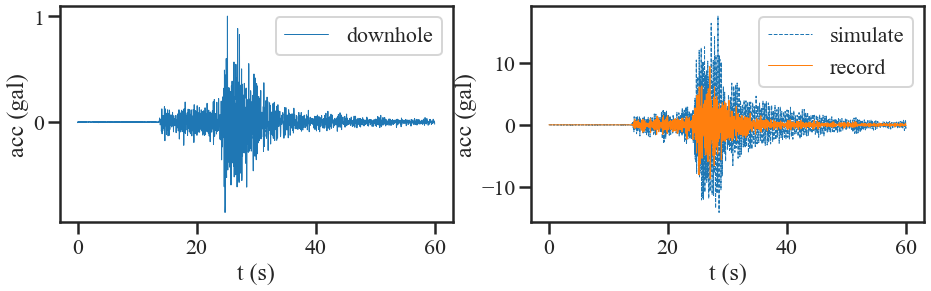

In [4]:
i = 23
t = np.linspace(0.02, 60, 3000)
plt.figure(figsize=((12, 3)))
plt.subplots_adjust(left=0,bottom=0,top=1,right=1,hspace=0.3,wspace=0.2)
plt.subplot(1, 2, 1)
plt.plot(t, dhacc[i, :], label='downhole', linewidth=1)
plt.xlabel('t (s)'), plt.ylabel('acc (gal)'), plt.legend(loc='upper right')
plt.subplot(1, 2, 2)
plt.plot(t, mdacc[i, :], '--', label='simulate', linewidth=1)
plt.plot(t, upacc[i, :], label='record', linewidth=1)
plt.xlabel('t (s)'), plt.ylabel('acc (gal)'), plt.legend(loc='upper right')

## 构造训练集、验证集和测试集

In [5]:
batch_size = 64
valid_size = 0.1
test_size = 0.1

numdata = dhacc.shape[0]
num_valid = int(valid_size * numdata)
num_test = int(test_size * numdata)
num_train = numdata - num_valid - num_test
index = list(range(numdata))
np.random.shuffle(index)
train_idx, valid_idx, test_idx = index[:num_train], index[num_train : num_train + num_valid], index[num_train + num_valid:]
# train_idx, valid_idx, test_idx = train_idx[0 : 500], valid_idx[0 : 15], test_idx[0 : 15]

data = scipy.io.loadmat(os.path.join(station + '_results', 'idx.mat'))
numdata = dhacc.shape[0]
index = list(range(numdata))
train_idx = data['train_idx'].ravel().tolist()
test_idx = data['test_idx'].ravel().tolist()
valid_idx = list(set(index) - set(train_idx) - set(test_idx))

train_data, train_label = dhacc[train_idx, :, None], mdacc[train_idx, :, None]
valid_data, valid_label = dhacc[valid_idx, :, None], mdacc[valid_idx, :, None]
test_data, test_label = dhacc[test_idx, :, None], mdacc[test_idx, :, None]

train_dataset = eqkDataset(train_data, train_label)
valid_dataset = eqkDataset(valid_data, valid_label)
test_dataset = eqkDataset(test_data, test_label)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(valid_dataset)
test_loader = torch.utils.data.DataLoader(test_dataset)

## 构建神经网络模型

In [6]:
class PhyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(PhyRNN, self).__init__()
        n = 3000
        phi1 = np.concatenate([np.array([-3 / 2, 2, -1 / 2]), np.zeros([n - 3, ])])
        temp1 = np.concatenate([-1 / 2 * np.identity(n - 2), np.zeros([n - 2, 2])], axis=1)
        temp2 = np.concatenate([np.zeros([n - 2, 2]), 1 / 2 * np.identity(n - 2)], axis=1)
        phi2 = temp1 + temp2
        phi3 = np.concatenate([np.zeros([n - 3, ]), np.array([1 / 2, -2, 3 / 2])])
        Phi_t = 1 / dt * np.concatenate([np.reshape(phi1, [1, phi1.shape[0]]), phi2, np.reshape(phi3, [1, phi3.shape[0]])], axis=0)
        Phi_t = torch.tensor(Phi_t)
        if torch.cuda.is_available():
            Phi_t = Phi_t.cuda()
        self.Phi_t = Phi_t
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        super(PhyRNN, self).__init__()
        self.rnnlayer = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True)

        self.fc = nn.Sequential(
            nn.Linear(self.hidden_size, 16),
            nn.ReLU(inplace=True),
            # nn.Tanh(),
            nn.Linear(16, 4),
            nn.ReLU(inplace=True),
            # nn.Tanh(),
            nn.Linear(4, 1)
        )
        # self._initial_parameters()
        

    def forward(self, x):
        x, (ht, ct) = self.rnnlayer(x)
        x = self.fc(x)
        
        x_t = torch.matmul(self.Phi_t, x[:, :, 0].permute(1, 0))
        x_tt = torch.matmul(self.Phi_t, x_t)
        x_tt = x_tt.permute(1, 0)
        
        return x_tt[:, :, None]
    
    
    def _initial_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.constant_(p, 0.05)
            else:
                nn.init.constant_(p, 0)

In [7]:
def PhyCNNLoss(output, target):
    # loss = torch.mean(((output - target)/torch.max(torch.abs(target))).pow(2))
    loss = torch.mean((output - target).pow(2))
    # loss = torch.mean((output_tt - target).pow(2)) + torch.mean(output.pow(2))
    return loss

In [8]:
max_epoch = 1000          
disp_freq = -1
learning_rate = 0.001
# Net = PhyCNN(Phi_t)
Net = PhyRNN(1, 32, 3)
# GPU加速
if torch.cuda.is_available():
    Net = Net.cuda()
# optimizer = torch.optim.LBFGS(Net.parameters(), lr=learning_rate, max_iter=2)
optimizer = torch.optim.Adam(Net.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
starttime = time.time()
train_best_model ,valid_best_model, last_model, train_loss, valid_loss = train(Net, PhyCNNLoss, optimizer, train_loader, valid_loader, max_epoch, disp_freq)
print('Training Time {:.4f}'.format(time.time()-starttime))
prediction = test(valid_best_model, PhyCNNLoss, test_loader)
torch.cuda.empty_cache()

Epoch [1/1000]	 Average training and validation loss: 2.2273E+00 2.5365E+00	Time: 4.40s
Epoch [2/1000]	 Average training and validation loss: 2.2222E+00 2.5295E+00	Time: 3.71s
Epoch [3/1000]	 Average training and validation loss: 2.2155E+00 2.5185E+00	Time: 3.62s
Epoch [4/1000]	 Average training and validation loss: 2.2047E+00 2.5009E+00	Time: 3.62s
Epoch [5/1000]	 Average training and validation loss: 2.1877E+00 2.4747E+00	Time: 3.60s
Epoch [6/1000]	 Average training and validation loss: 2.1638E+00 2.4423E+00	Time: 3.61s
Epoch [7/1000]	 Average training and validation loss: 2.1387E+00 2.4197E+00	Time: 3.60s
Epoch [8/1000]	 Average training and validation loss: 2.1275E+00 2.4167E+00	Time: 3.59s
Epoch [9/1000]	 Average training and validation loss: 2.1182E+00 2.4041E+00	Time: 3.60s
Epoch [10/1000]	 Average training and validation loss: 2.1007E+00 2.3944E+00	Time: 3.60s
Epoch [11/1000]	 Average training and validation loss: 2.0888E+00 2.3867E+00	Time: 3.59s
Epoch [12/1000]	 Average train

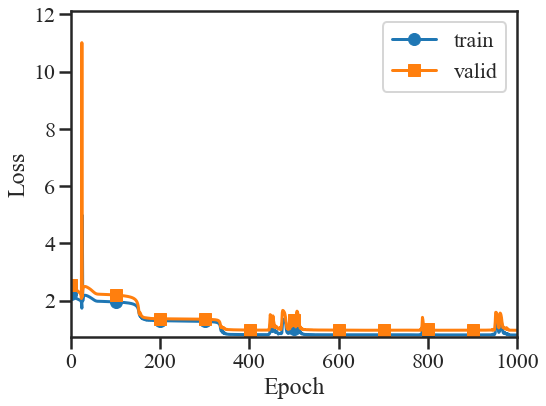

In [9]:
plot_loss(train_loss, valid_loss)
torch.save(train_best_model, os.path.join(station + '_results', 'simulate_LSTM', 'trainbest.pt'))
torch.save(valid_best_model, os.path.join(station + '_results', 'simulate_LSTM', 'validbest.pt'))
torch.save(last_model, os.path.join(station + '_results', 'simulate_LSTM', 'last.pt'))

In [10]:
train_pred = np.zeros(train_data.shape)
pbar = tqdm(range(train_data.shape[0]), desc='计算中', ncols=100)
for i in pbar:
    y = valid_best_model(torch.tensor(train_data[i:i+1, :, :]).cuda())
    train_pred[i, :, :] = y.cpu().detach().numpy()
    train_data[i, :, 0] = train_data[i, :, 0] * PGA_dh[train_idx[i]]
    train_label[i, :, 0] = train_label[i, :, 0] * PGA_dh[train_idx[i]]
    train_pred[i, :, 0] = train_pred[i, :, 0] * PGA_dh[train_idx[i]]

计算中: 100%|█████████████████████████████████████████████████████| 190/190 [00:15<00:00, 12.55it/s]


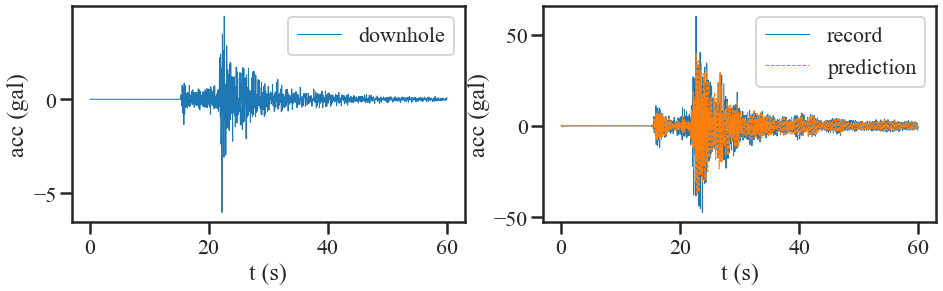

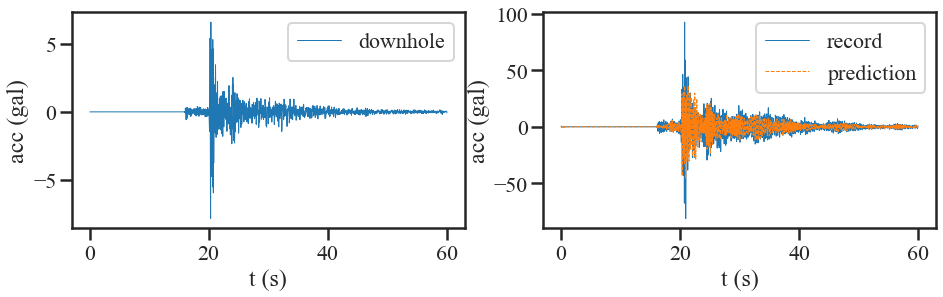

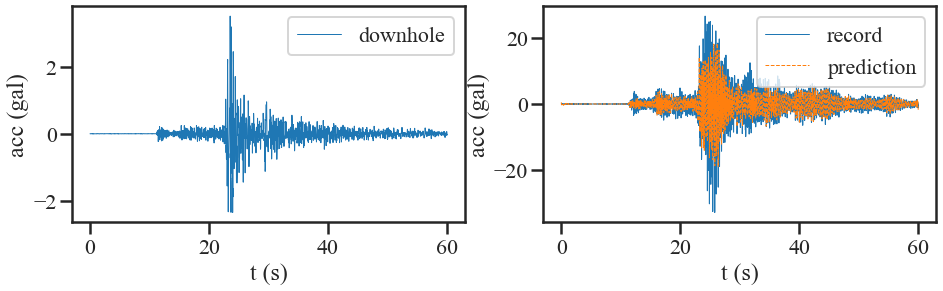

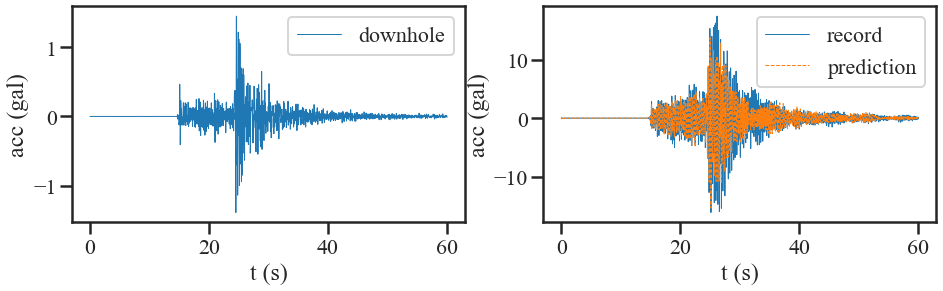

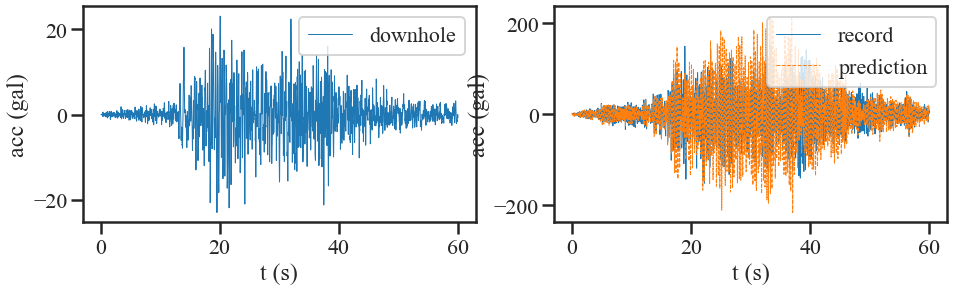

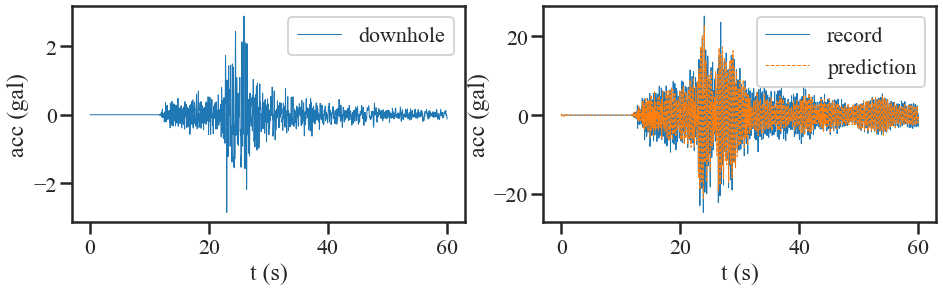

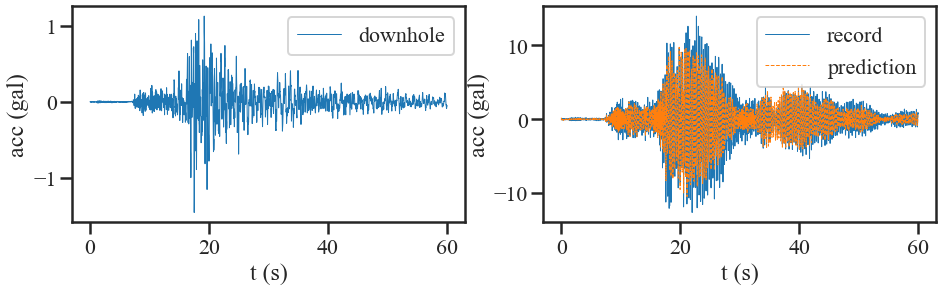

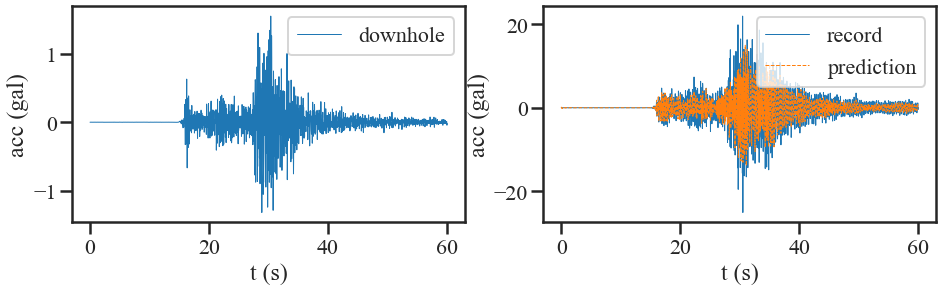

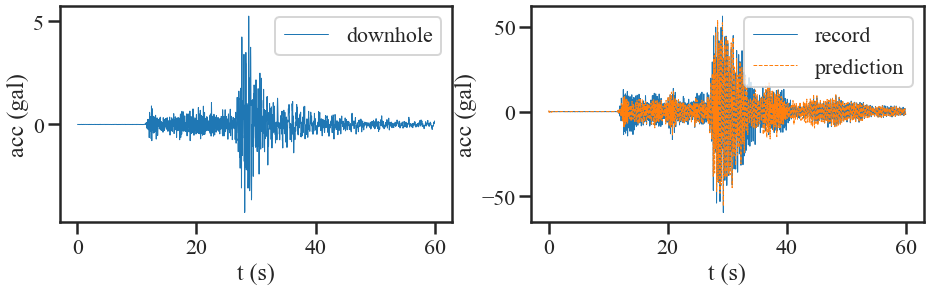

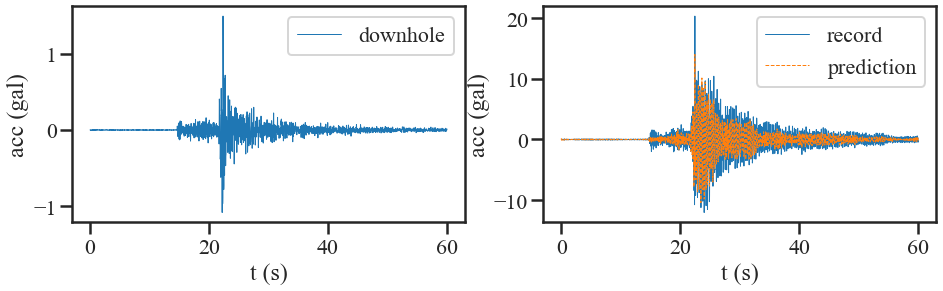

In [11]:
dof = 0
# for i in range(0, train_pred.shape[0]):
for i in range(0, train_pred.shape[0], int(train_pred.shape[0] / 10)):
    plt.figure(figsize=((12, 3)))
    plt.subplots_adjust(left=0,bottom=0,top=1,right=1,hspace=0.3,wspace=0.2)
    plt.subplot(1, 2, 1)
    plt.plot(t, train_data[i, :, dof], label='downhole', linewidth=1)
    plt.xlabel('t (s)'), plt.ylabel('acc (gal)'), plt.legend(loc='upper right')
    plt.subplot(1, 2, 2)
    plt.plot(t, train_label[i, :, dof], label='record', linewidth=1)
    plt.plot(t, train_pred[i, :, dof], '--', label='prediction', linewidth=1)
    plt.xlabel('t (s)'), plt.ylabel('acc (gal)'), plt.legend(loc='upper right')
    # plt.savefig(os.path.join(station + '_results', 'simulate_LSTM', 'figures', 'train{:d}.svg'.format(i)))
    # plt.close()

In [12]:
test_pred = valid_best_model(torch.tensor(test_data).cuda())
test_pred = test_pred.cpu().detach().numpy()
for i in range(test_data.shape[0]):
    test_data[i, :, 0] = test_data[i, :, 0] * PGA_dh[test_idx[i]]
    test_label[i, :, 0] = test_label[i, :, 0] * PGA_dh[test_idx[i]]
    test_pred[i, :, 0] = test_pred[i, :, 0] * PGA_dh[test_idx[i]]
torch.cuda.empty_cache()

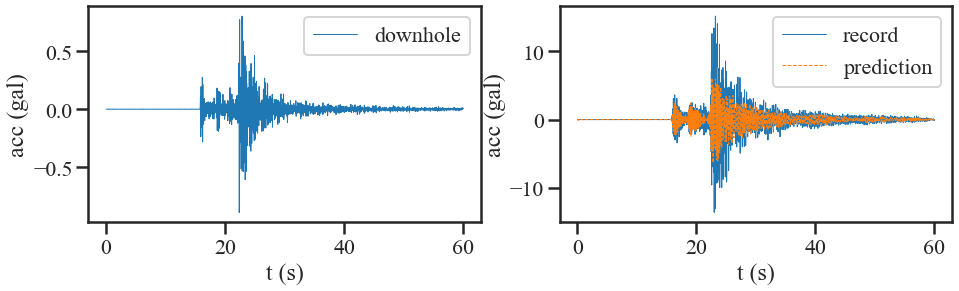

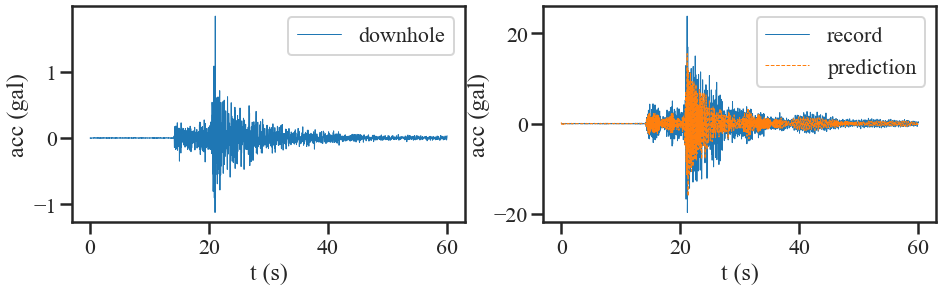

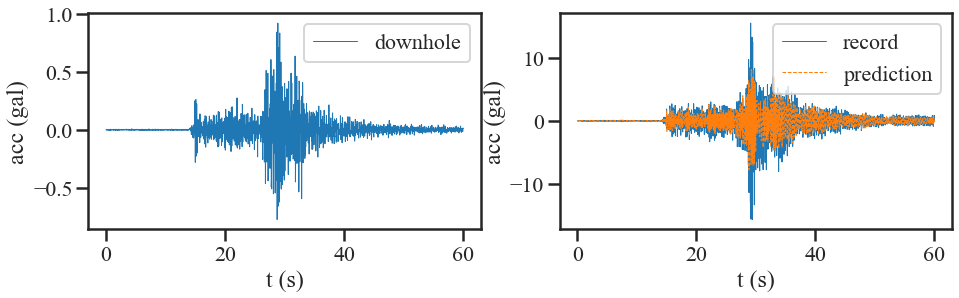

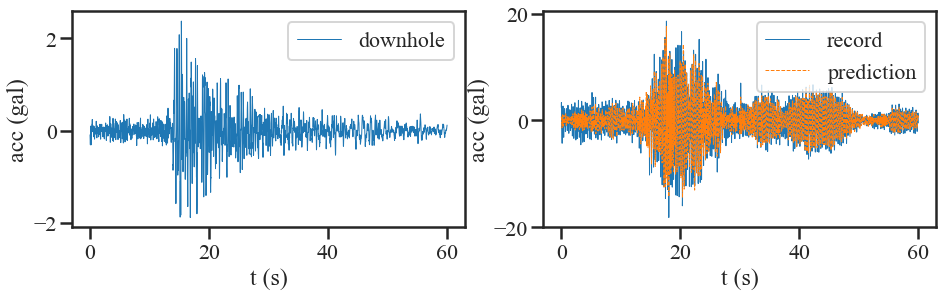

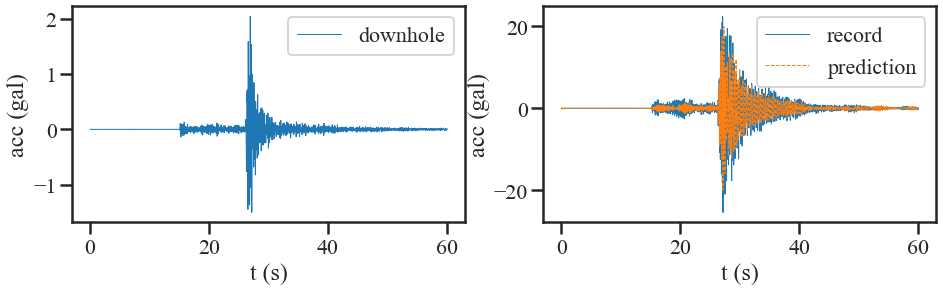

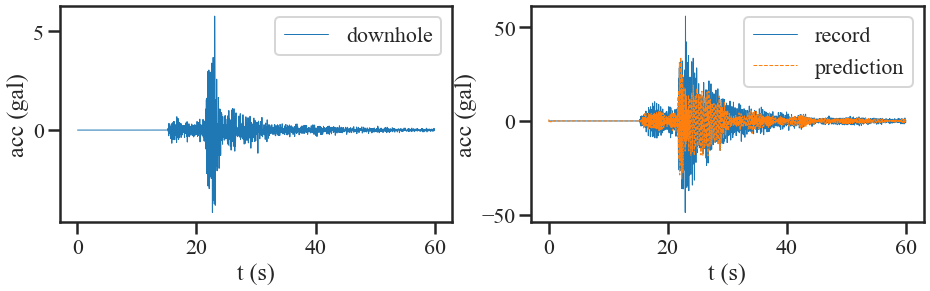

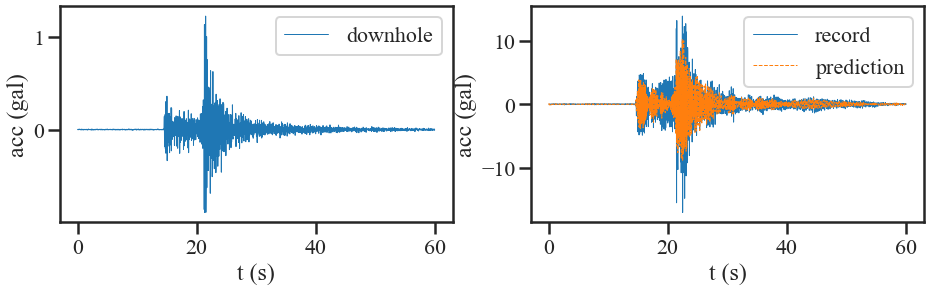

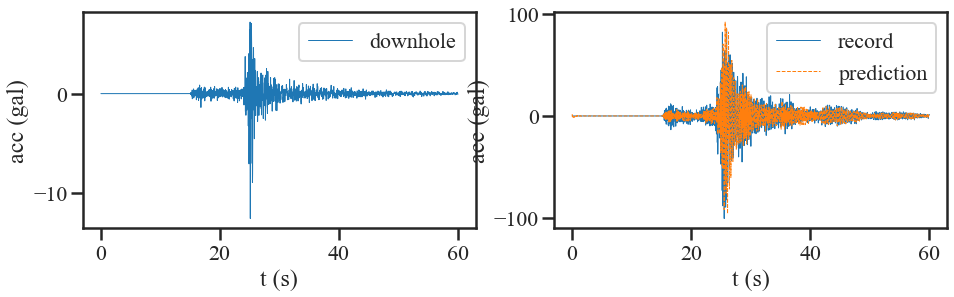

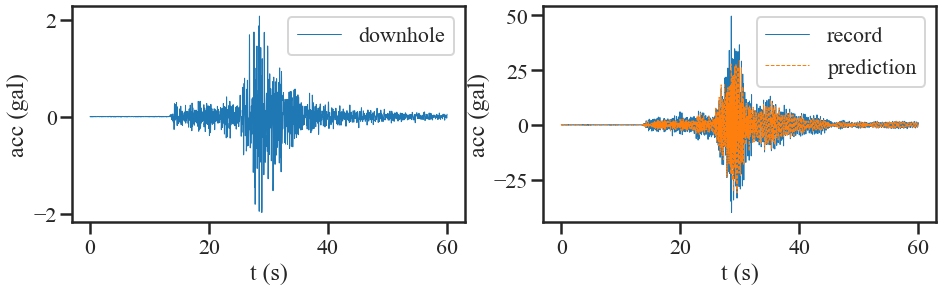

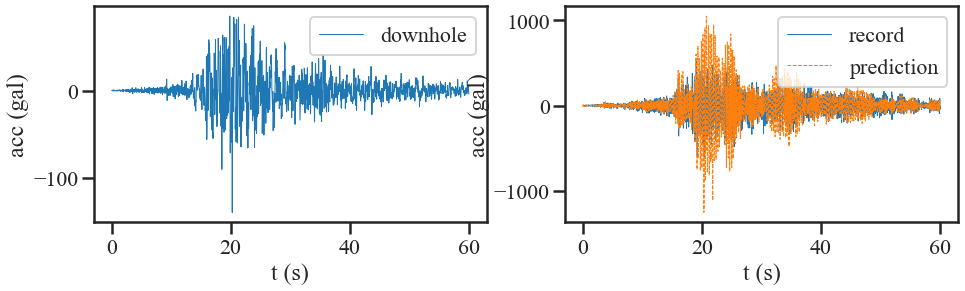

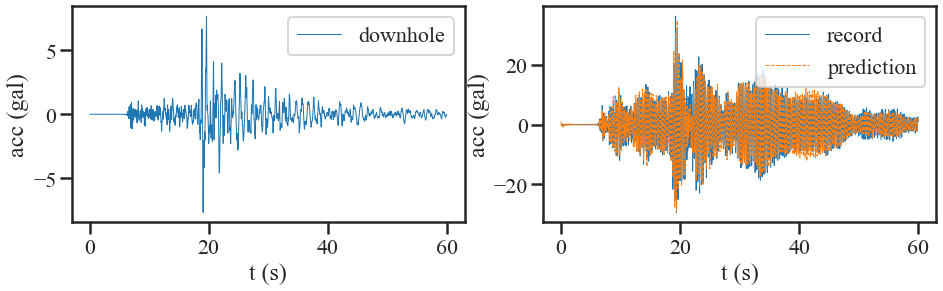

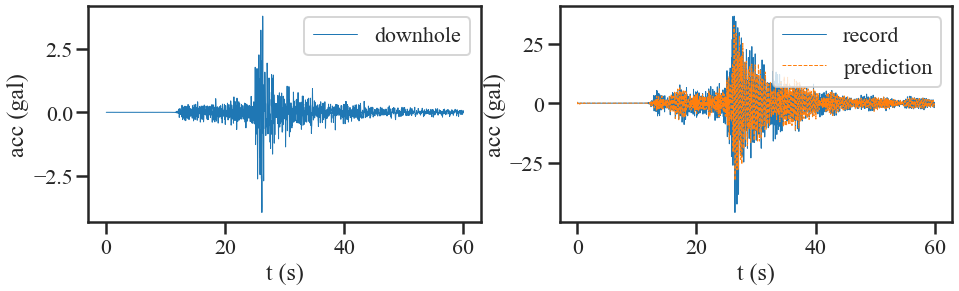

In [13]:
dof = 0
for i in range(0, test_pred.shape[0], int(test_pred.shape[0]/10)):
# for i in range(0, test_pred.shape[0]):
    plt.figure(figsize=((12, 3)))
    plt.subplots_adjust(left=0,bottom=0,top=1,right=1,hspace=0.3,wspace=0.2)
    plt.subplot(1, 2, 1)
    plt.plot(t, test_data[i, :, dof], label='downhole', linewidth=1)
    plt.xlabel('t (s)'), plt.ylabel('acc (gal)'), plt.legend(loc='upper right')
    plt.subplot(1, 2, 2)
    plt.plot(t, test_label[i, :, dof], label='record', linewidth=1)
    plt.plot(t, test_pred[i, :, dof], '--', label='prediction', linewidth=1)
    plt.xlabel('t (s)'), plt.ylabel('acc (gal)'), plt.legend(loc='upper right')
    # plt.savefig(os.path.join(station + '_results', 'simulate_LSTM', 'figures', 'test{:d}.svg'.format(i)))
    # plt.close()

In [14]:
scipy.io.savemat(os.path.join(station + '_results', 'simulate_LSTM', 'result.mat'),
                 {'train_data': train_data, 'train_idx': train_idx, 'valid_idx': valid_idx, 'test_idx': test_idx, 'train_label': train_label, 'train_pred': train_pred, 'test_data': test_data,
                  'test_label': test_label, 'test_pred': test_pred, 'train_loss': train_loss, 'valid_loss': valid_loss, 'time': t, 'dt': dt})